In [1]:
## 1.Simple EDA
### 1.1  Data Loading
### 1.2 Relations: Numerical Features
### 1.3 Relations: Categorical Features
#-----
# 2. Preprocessing
### 2.1 필요데이터 추가, 변경
### 2.2 Data Cleaning : Missing values, Outliers
### 2.3. TimeSeries Features 추가, 변경
### 2.4 Categorical Encoding : Label

# 3. Machine Learning: Light GBM 

## 1.Simple EDA
### 1.1  Data Loading

In [2]:
# Loading packages
#importing all the required ML packages
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression #logistic regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split #training and testing data split
from sklearn import metrics #accuracy measure
from sklearn.metrics import confusion_matrix #for confusion matrix
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt  # Matlab-style plotting
from datetime import timedelta, date, datetime
import seaborn as sns
from scipy.stats import norm, skew #for some statistics
start_time = datetime.now()
rpath ='/home/bono/local_drive_u/117_apt/'
#pd.options.display.float_format = '{:,.2f}'.format

In [3]:
# 데이터 로딩 & merge
train_df = pd.read_csv(rpath + 'train.csv')
test_df = pd.read_csv(rpath +  'test.csv')
addr_df = pd.read_csv(rpath + 'addr_cd.csv')
schools_df = pd.read_csv(rpath+ 'Schools.csv')
subway_df = pd.read_csv(rpath+ 'Subways.csv')

train_df = train_df.merge(addr_df[['code','bcode','bname','name']], left_on = 'address_by_law', right_on = 'code')
test_df = test_df.merge(addr_df[['code','bcode','bname','name']], left_on = 'address_by_law', right_on = 'code', how = 'left')

all_df = pd.concat([train_df, test_df], keys=['train', 'test'],  names =['TRTE'])
all_df.index = all_df.index.droplevel(1)
all_df.set_index('key', append = True, inplace = True)
#all_df[all_df.index.duplicated()]
all_df.shape

(1605376, 28)

In [4]:
# 테스트 3912 아파트를 대상으로 TRAIN 모든 기간에 생성 (3918 * 462)

# d1 = all_df.groupby(['transaction_year_month','transaction_date'])['apartment_id'].count().reset_index()
# d1.drop(['apartment_id'], axis= 1, inplace = True)
# d1['key'] = 1
# all_df.reset_index(inplace= True)
# df_train = all_df.query("TRTE == 'train'").copy()
# df_test = all_df.query("TRTE == 'test'").copy()
# df_test['key'] = 1
# df_test.drop(['transaction_year_month','transaction_date'], axis= 1, inplace = True)
# df_test = df_test.merge(d1,on='key')
# all_df = pd.concat([df_train[df_train.columns], df_test[df_train.columns]]).set_index(['TRTE','key'])
# all_df.shape

In [5]:
num_cols = ['year_of_completion', 'exclusive_use_area','supply_area','room_count','bathroom_count','total_parking_capacity_in_site'
,'total_household_count_in_sites', 'apartment_building_count_in_sites','tallest_building_in_sites','lowest_building_in_sites','floor']

cat_cols = ['apartment_id', 'city', 'transaction_year_month','transaction_date', 'address_by_law','tran_yymmd','bcode','heat_type','heat_fuel', 'front_door_structure']
non_use = ['key','apartment_id','latitude','longitude','room_id','date_trans']

cat_cols_small = ['heat_type','heat_fuel', 'front_door_structure']

### 1.2 Relations: Numerical Features
* TARGET 변수인 transaction_real_price과 숫자변수의 상관관계를 살펴봄
* supply_area, exclusive_use_area 등이 TARGET 변수와 높은 관계를 가지고 있음
* floor, year_of_completion(아파트 건축년도)는 낮은 관계를 지니고 있음

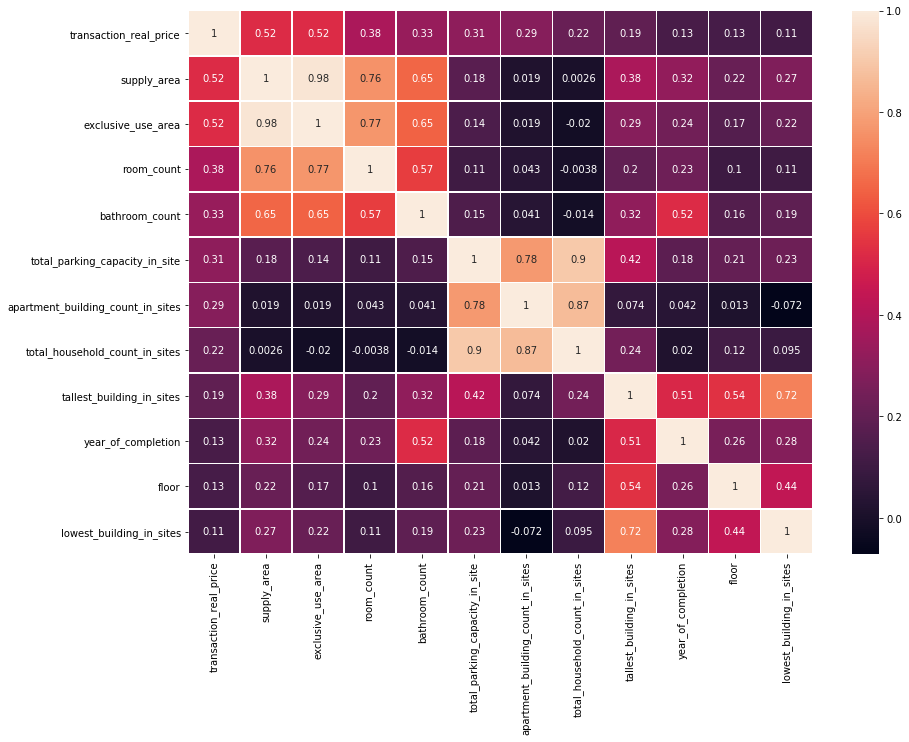

In [6]:
train_df[['transaction_real_price'] + num_cols ].corr()['transaction_real_price'].sort_values(ascending = False).index
cor_matx  = train_df[train_df[['transaction_real_price'] + num_cols ].corr()['transaction_real_price'].sort_values(ascending = False).index ].corr()

fig, ax = plt.subplots(figsize=(14,10))   
sns.heatmap(cor_matx, annot=True, linewidths=.5, ax=ax)
for item in ax.get_yticklabels():
    item.set_rotation(0)

for item in ax.get_xticklabels():
    item.set_rotation(90)
plt.show()

### 1.3 Relations: Categorical Features

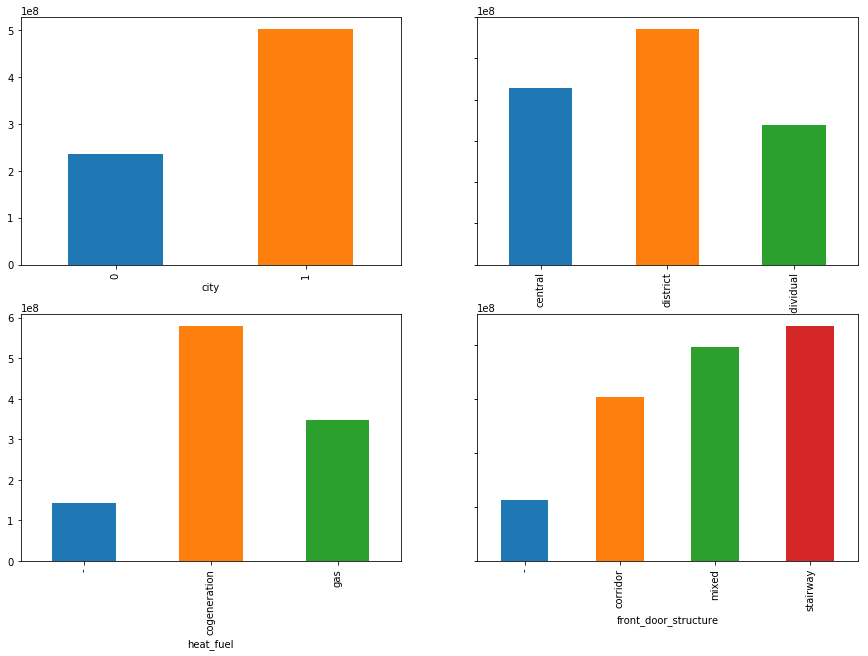

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
(train_df.groupby(['city'])['transaction_real_price'].mean()).plot(kind = 'bar' , sharey  = True, ax = axes[0,0] )
(train_df.groupby(['heat_type'])['transaction_real_price'].mean()).plot(kind = 'bar' , sharey  = True, ax = axes[0,1])
(train_df.groupby(['heat_fuel'])['transaction_real_price'].mean()).plot(kind = 'bar' , sharey  = True, ax = axes[1,0] )
(train_df.groupby(['front_door_structure'])['transaction_real_price'].mean()).plot(kind = 'bar' , sharey  = True, ax = axes[1,1] )
#at_cols = ['apartment_id', 'city', 'transaction_year_month','transaction_date', 'address_by_law','tran_yymmd','bcode','heat_type','heat_fuel', 'front_door_structure']

In [8]:
#
cat_cols = all_df.dtypes[all_df.dtypes == "object"].index
#for col in ['bname','name']:
for col in ['bname']:
    #print(all_df[col].unique())
    print(all_df.loc["train"].groupby(col)['transaction_real_price'].agg(['mean','count']))
# for a in train_df.heat_type.unique():
#     if isinstance(a, str):
#         train_df[train_df['heat_type']== a][['TARGET'] + num_cols].hist()
#         plt.plot()

                    mean   count
bname                           
부산광역시 강서구   3.360431e+08   16558
부산광역시 금정구   2.450679e+08   24154
부산광역시 기장군   2.048850e+08   25575
부산광역시 남구    2.624537e+08   69089
부산광역시 동구    2.436017e+08    5242
부산광역시 동래구   2.542865e+08   35109
부산광역시 부산진구  1.966319e+08   57829
부산광역시 북구    1.760144e+08   70219
부산광역시 사상구   1.429273e+08   40653
부산광역시 사하구   1.530574e+08   60155
부산광역시 서구    2.153037e+08    5317
부산광역시 수영구   2.989054e+08   19509
부산광역시 연제구   2.578611e+08   31336
부산광역시 영도구   1.424886e+08   13055
부산광역시 중구    1.336235e+08    1246
부산광역시 해운대구  3.250713e+08  125040
서울특별시 강남구   9.955627e+08   56116
서울특별시 강동구   4.921772e+08   41209
서울특별시 강북구   3.312908e+08   19653
서울특별시 강서구   4.137709e+08   59449
서울특별시 관악구   3.685345e+08   33173
서울특별시 광진구   5.753149e+08   20664
서울특별시 구로구   3.489575e+08   48920
서울특별시 금천구   2.842858e+08   15478
서울특별시 노원구   2.777514e+08  110447
서울특별시 도봉구   2.663568e+08   56426
서울특별시 동대문구  3.898577e+08   32504
서울특별시 동작구   5.140259e+08   49547
서울특별시 마포구 

## 2. Preprocessing

### 2.1 필요데이터 추가, 변경

In [9]:
# 가장 가까운 거리(맨하타 거리 최소화)에 있는 지하철역과 학교를 매핑

apt_master = all_df[['apartment_id','latitude','longitude']].drop_duplicates('apartment_id')

def find_subway(cols):
    _latitude = cols[0]
    _longitude = cols[1]
    subway_df['diff'] = abs(subway_df['latitude'] -  _latitude) +  abs(subway_df['longitude'] -  _longitude)
    return subway_df.sort_values('diff')[['station_id']].iloc[0]

def find_school(cols):
    _latitude = cols[0]
    _longitude = cols[1]
    schools_df['diff'] = abs(schools_df['latitude'] -  _latitude) +  abs(schools_df['longitude'] -  _longitude)
    return schools_df.sort_values('diff')[['school_code']].iloc[0]

apt_master['subway_id'] = apt_master[['latitude','longitude']].apply(lambda x:find_subway(x), axis = 1)
apt_master['school_id'] = apt_master[['latitude','longitude']].apply(lambda x:find_school(x), axis = 1)
all_df = all_df.reset_index().merge(apt_master[['apartment_id','school_id','subway_id']], on = 'apartment_id').set_index(['TRTE','key'])

In [10]:
# 위도와 경도 데이터를 이용해서 클러스터링
from sklearn.cluster import MiniBatchKMeans
coords = np.vstack((all_df[['longitude', 'latitude']].values))
kmeans = MiniBatchKMeans(n_clusters=100, batch_size=10000).fit(coords)
all_df.loc[:, 'dis_cluster'] = kmeans.predict(all_df[['longitude', 'latitude']])

In [11]:
# TARGET 으로 명시, 건축년도에서 사용연도로 변경, 재개발 아파트 
all_df.rename(columns = {'transaction_real_price':'TARGET_PRICE'}, inplace = True)
all_df['apt_use_year'] = all_df['transaction_year_month'].map(str).str[:4].map(int) - all_df['year_of_completion']
all_df['apt_room_id'] = all_df['apartment_id'].astype('str') +'_'+ all_df['room_id'].astype('str')
all_df['recons'] = all_df[['year_of_completion','bname']].apply(lambda cols: 1  if (cols[0] < 1982) & (cols[1] in (['서울특별시 서초구','서울특별시 강남구','서울특별시 강동구','서울특별시 송파구']))   else 0 ,  axis = 1   )


### 2.2 Data Cleaning : Missing values

In [12]:
# 데이터가 없으면 평균 값, 문자값, 0으로 변경함

all_df['tallest_building_in_sites'].fillna(all_df['tallest_building_in_sites'].mean(),inplace= True)
all_df['lowest_building_in_sites'].fillna(all_df['lowest_building_in_sites'].mean(),inplace= True)

all_df['bathroom_count'].fillna(1,inplace= True)
all_df['room_count'].fillna(1,inplace= True)

all_df['heat_type'].fillna('nullna',inplace= True)
all_df['heat_fuel'].fillna('nullna',inplace= True)
all_df['front_door_structure'].fillna('nullna',inplace= True)


In [13]:
# 
all_df['val_check'] = all_df['bname'].apply(lambda x:1 if x in ['서울특별시 강남구', '서울특별시 서초구','서울특별시 송파구','서울특별시 강동구','서울특별시 용산구','서울특별시 성동구','서울특별시 광진구','서울특별시 동작구'] else 0)
all_df['supply_cate'] =  all_df['supply_area'].agg(lambda x :0 if x < 80 else (1 if x < 120 else 2 ))

### 2.3. TimeSeries Features 추가, 변경

In [14]:
all_df['mdt_yyyy'] = all_df['transaction_year_month'].astype('str').str[:4]
all_df['mdt_yymmdx'] = all_df['transaction_year_month'].map(str)+ all_df['transaction_date']
dict_d= {"1~10":1,"11~20":2,"21~31":3,"21~30":3,"21~29":3,"21~28":3}
all_df['mdt_day10'] = all_df['transaction_date'].map(dict_d)
all_df['mdt_yymm123'] = all_df['transaction_year_month'].map(str)+'_'+ all_df['mdt_day10'].map(str)
dict_s = {1:1, 2:11,3:21}
all_df['mdt_yyyymm_date']  = all_df['mdt_yymm123'].apply(lambda x: date(int(str(x)[:4]),int(str(x)[4:6]),(dict_s[int(str(x[7]))])))
all_df['mdt_yyyymm_date']  = pd.to_datetime(all_df['mdt_yyyymm_date'])

In [15]:
all_df['mdt_quarter'] = all_df['mdt_yyyymm_date'].dt.year.map(str) + '_' + all_df['mdt_yyyymm_date'].dt.quarter.map(str)

In [16]:
df_map = all_df['mdt_yymm123'].value_counts().sort_index().to_frame()

In [17]:
df_map['ab_2'] = df_map.index.str[:6]
df_map['ab_3'] = df_map.index.str[:6]
df_map['ab_2'] = df_map['ab_3'].shift(1)
df_map['ab_3'] = df_map['ab_3'].shift(2)
df_map.fillna(method= 'bfill', inplace = True)
all_df['mdt_yymmdx2'] = all_df['mdt_yymm123'].map(df_map['ab_2'].to_dict())
all_df['mdt_yymmdx3'] = all_df['mdt_yymm123'].map(df_map['ab_3'].to_dict())

In [18]:
# TARGET을 평당가로 만들어 주기 위해 추가 
all_df['TARGET_PYUNG'] = all_df['TARGET_PRICE'] / all_df['supply_area']  / 0.3025

### 2.4 Categorical Encoding : Label

In [19]:
cat_cols = ['apartment_id', 'city', 'transaction_year_month','transaction_date', 'address_by_law','mdt_yymmdx','mdt_yymm123','bcode','heat_type','heat_fuel', 'front_door_structure', 'recons','mdt_yyyy','supply_cate']
cat_cols_add =['mdt_day10','mdt_quarter','mdt_yymmdx2','mdt_yymmdx3','apt_room_id','dis_cluster', 'school_id', 'subway_id']
cat_cols.extend(cat_cols_add)


In [20]:
num_cols = ['year_of_completion','exclusive_use_area','supply_area','room_count','bathroom_count','total_parking_capacity_in_site'
,'total_household_count_in_sites', 'apartment_building_count_in_sites','tallest_building_in_sites','lowest_building_in_sites','floor','apt_use_year']


In [21]:
for col in cat_cols:
    #print(col)
    lbl = LabelEncoder()
    lbl.fit(all_df[col].values.astype('str'))
    all_df[col] = lbl.transform(list(all_df[col].values.astype('str')))
    

## 3. Machine Learning

In [22]:
all_df.rename(columns = {'TARGET_PYUNG':'TARGET'}, inplace = True)
all_df['TARGET'] = np.log1p(all_df['TARGET'])
train_df = all_df.loc['train']
test_df = all_df.loc['test']

In [23]:
train_df = train_df.query("mdt_yyyymm_date >= datetime(2013, 1, 1)")

In [24]:
from sklearn.model_selection import KFold, StratifiedKFold
KFOLDS = 4
folds = KFold(n_splits = KFOLDS, shuffle=True, random_state=123)
oof_preds = np.zeros(train_df.shape[0])
sub_preds = np.zeros(test_df.shape[0])
oof_reg_preds = np.zeros(train_df.shape[0])
sub_reg_preds  = np.zeros(test_df.shape[0])
_learning_rate = 0.2

In [25]:
params={'learning_rate': _learning_rate,
        'objective':'regression',
        'metric':'rmse',
        'num_leaves': 31,
        'verbose': 1,
        'bagging_fraction': 0.9,
        'feature_fraction': 0.9,
        "random_state":42,
        'max_depth': 5,
        "bagging_seed" : 42,
        "verbosity" : -1,
        "bagging_frequency" : 5,
        'lambda_l2': 0.5,
        'lambda_l1': 0.5,
        'min_child_samples': 36
       }

In [26]:
train_y = (train_df["TARGET"])
test_X = test_df[num_cols + cat_cols]
importances = pd.DataFrame()
for n_fold, (trn_idx, val_idx) in enumerate(folds.split(train_df)):
    #print(n_fold)
    #print(val_idx)
    trn_X, trn_y = train_df[num_cols + cat_cols].iloc[trn_idx], train_y.iloc[trn_idx]
    val_X, val_y = train_df[num_cols + cat_cols].iloc[val_idx], train_y.iloc[val_idx]
    print(trn_X.shape)
    
    reg = lgb.LGBMRegressor(**params,n_estimators=2000)
    print("-"* 20 + str(n_fold) + "_n_fold"  + "-"* 20)
    print("-"* 20 + "LightGBM Training" + "-"* 20)
    reg.fit(trn_X, (trn_y),eval_set=[(trn_X, trn_y),(val_X, val_y)],early_stopping_rounds=500,verbose=1000,eval_metric='rmse')
    
    imp_df = pd.DataFrame()
    #imp_df['feature'] = train_features
    imp_df['gain_reg'] = reg.booster_.feature_importance(importance_type='gain')
    imp_df['fold'] = n_fold + 1
    importances = pd.concat([importances, imp_df], axis=0, sort=False)
    oof_reg_preds[val_idx] = reg.predict(val_X, num_iteration=reg.best_iteration_)
    #oof_reg_preds[oof_reg_preds < 0] = 0
    lgb_preds = reg.predict(test_X, num_iteration=reg.best_iteration_)
    #lgb_preds[lgb_preds < 0] = 0
    
    sub_reg_preds += (lgb_preds) / KFOLDS
    #print(sub_reg_preds)

(648318, 34)
--------------------0_n_fold--------------------
--------------------LightGBM Training--------------------
Training until validation scores don't improve for 500 rounds.
[1000]	training's rmse: 0.0571443	valid_1's rmse: 0.0592994
[2000]	training's rmse: 0.0507683	valid_1's rmse: 0.0540822
Did not meet early stopping. Best iteration is:
[2000]	training's rmse: 0.0507683	valid_1's rmse: 0.0540822
(648318, 34)
--------------------1_n_fold--------------------
--------------------LightGBM Training--------------------
Training until validation scores don't improve for 500 rounds.
[1000]	training's rmse: 0.057344	valid_1's rmse: 0.0587715
[2000]	training's rmse: 0.0510388	valid_1's rmse: 0.0534644
Did not meet early stopping. Best iteration is:
[2000]	training's rmse: 0.0510388	valid_1's rmse: 0.0534644
(648318, 34)
--------------------2_n_fold--------------------
--------------------LightGBM Training--------------------
Training until validation scores don't improve for 500 roun

In [32]:
oof_reg_preds

array([16.51690902, 16.6501953 , 16.5637068 , ..., 17.59022785,
       15.95396496, 16.44442255])

In [27]:

test_df['pred'] = np.expm1(sub_reg_preds) * test_df['supply_area'] * 0.3025
train_df['pred'] = np.expm1(oof_reg_preds) * train_df['supply_area'] * 0.3025

In [35]:
test_df['pred'].describe().to_frame('te').join(train_df['pred'].describe().to_frame('tr'))

,te,tr
count,3.918000e+03,8.644240e+05
mean,6.116494e+08,4.703159e+08
std,4.953499e+08,3.428182e+08
min,2.179061e+07,1.469870e+07
25%,2.888456e+08,2.600983e+08
50%,4.829081e+08,3.878085e+08
75%,7.574684e+08,5.695553e+08
max,5.700184e+09,6.510222e+09
